### 미션 소개
Hugging Face transformers 라이브러리를 사용하여 문서 요약 모델을 구현하는 미션입니다. 데이터 로드 및 전처리부터 요약 모델 실행, 결과 평가까지 전체 파이프라인을 구축해 보세요.

### 사용 데이터셋
[AI HUB 문서요약 텍스트](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=97)

### 데이터셋
JSON 파일 형태로 제공되며, 3종류(신문 기사, 사설, 법률)의 문서 중 일부만 사용.

# 통합 데이터 로드 및 전처리

In [ ]:
import os
from tqdm import tqdm
import json
from datasets import load_dataset, Dataset, DatasetDict
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import transformers
from transformers import BartTokenizerFast
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast
from transformers import Trainer

# from transformers import TrainingArguments
from transformers import pipeline

# 데이터 로드 및 flatten

In [ ]:
# JSON 파일 로드
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        raw = json.load(f)
    return raw['documents']    # raw['documents'] : JSON 파일 안에서 요약 학습에 사용할 문서들이 저장된 핵심 리스트

In [ ]:
# JSON으로 구성된 복잡한 문서 구조를 BART 학습에 맞게 평탄화(flatten)하여 간단한 텍스트 형태로 변환
# 하나의 document JSON 객체를 입력으로 받아, 학습용 평탄화 딕셔너리로 변환
def flatten_document(doc, doc_type):
    paragraphs = doc['text']    # 2차원 리스트.  문장은 2중 리스트로 구성되어 있음 ([[{}, {}, ...], [{}, ...]])
    sentences = [s['sentence'] for p in  paragraphs for s in p]    # 2중 리스트를 평탄화(flatten)하며 각 객체에서 "sentence" 텍스트 추출
    full_text = ' '.join(sentences)    # 평탄화된 문장들을 하나의 긴 문자열로 합침

    summary = doc['abstractive'][0] if doc['abstractive'] else ""    # abstractive 요약이 존재하면 첫 번째 문장을 사용

    return {
        'id': doc['id'],
        'text': full_text,
        'summary': summary,
        'type': doc_type
    }

In [ ]:
def load_dataset_flat(file_path, doc_type, max_samples = None):
    raw_docs = load_json(file_path)
    if max_samples is not None:
        raw_docs = raw_docs[:max_samples] # 앞에서 n개만 사용
    return [flatten_document(doc, doc_type) for doc in tqdm(raw_docs)]

#### ※ 참고 ※

- 대부분의 학습용 문서 데이터는 nested 구조 ([paragraph][sentence])로 되어 있어서 학습 전 평탄화가 필수이다.
- "abstractive"는 사람이 직접 쓴 요약을 의미

In [ ]:
cd /content/drive/MyDrive/Projects/문서 요약

/content/drive/MyDrive/Projects/문서 요약


In [ ]:
# 파일 경로 설정
train_files = {
    "editorial": "./summarization/train_original_editorial.json",
    "law": "./summarization/train_original_law.json",
    "news": "./summarization/train_original_news.json"
}

valid_files = {
    "editorial": "./summarization/valid_original_editorial.json",
    "law": "./summarization/valid_original_law.json",
    "news": "./summarization/valid_original_news.json"
}

In [ ]:
# 통합 데이터셋 생성
train_data = []
valid_data = []

for doc_type, path in train_files.items():
    train_data.extend(load_dataset_flat(path, doc_type, max_samples=5000))

for doc_type, path in valid_files.items():
    valid_data.extend(load_dataset_flat(path, doc_type, max_samples=500))

100%|██████████| 500/500 [00:00<00:00, 160910.92it/s]


# Hugging Face Dataset으로 변환


In [ ]:
# Hugging Face DatasetDict 형태로 데이터를 변환하여 Trainer에 바로 넘길 수 있도록 함.
train_dataset = Dataset.from_list(train_data)
valid_dataset = Dataset.from_list(valid_data)

In [ ]:
# Dataset.from_list()?
# Python의 리스트 형태 데이터를 Hugging Face의 Dataset 객체로 변환해주는 함수
# Hugging Face에서는 Trainer나 .map(), tokenizer() 등을 사용하려면 반드시 Dataset 형식이어야 함.
# 다른 방법은 없을까? 있다. 1. Dataset.from_dict() 2. load_dataset()
# 하지만, 본 프로젝트에서는 이미 리스트 형태로 정리된 데이터를 가지고 있기에 '.from_list'가 적절

In [ ]:
dataset = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset
})

# BART tokenizer 및 model 불러오기

In [ ]:
model_checkpoint = "gogamza/kobart-summarization"
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_checkpoint)
model = BartForConditionalGeneration.from_pretrained(model_checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
You passed along `num_labels=3` 

# Tokenize 전처리 함수
입력(text)과 타겟(summary)을 각각 모델이 이해할 수 있는 input_ids, labels로 변환

In [ ]:
max_input_length = 512     # 제한된 자원으로 길이 축소
max_target_length = 128

In [ ]:
def preprocess(example):
    # 원문 입력 토크나이징
    model_input = tokenizer(
        example["text"],    # text: 입력 문장 (원문 전체)
        max_length = max_input_length,    # max_length=1024 : BART가 수용할 수 있는 최대 토큰 수
        padding = "max_length",    # padding="max_length": 짧은 문장은 <pad>로 길이 고정
        truncation = True   # 너무 긴 문장은 자름
    )

    # 요약문 타겟 토크나이징
    with tokenizer.as_target_tokenizer():   # as_target_tokenizer() : BART 계열에서 타겟 전용 토크나이징을 지정할 때 필요함.
        label = tokenizer(
            example["summary"],    # summary : 타겟 시퀀스 (모델이 생성해야 할 정답)
            # padding="max_length"와 truncation=True는 GPU 배치 구성에 매우 중요
            max_length = max_target_length, 
            padding = "max_length",    # 고정된 길이로 맞추기 위해 빈 부분에 <pad> 토큰 채움
            truncation = True    # 길이가 너무 길 경우 잘라냄
        )

    # 레이블 정보 추가
    model_input["labels"] = label["input_ids"]  # 모델 학습에 사용할 정답 시퀀스를 "labels"라는 키로 추가 / Trainer가 이 값을 참조하여 Loss 계산
    return model_input

In [ ]:
# as_target_tokenizer()
# BART 기반 모델은 입력(input)과 출력(target) 토크나이징 설정이 서로 다를 수 있기에 as_target_tokenizer()가 필요하다.

# BART는 입력엔 [CLS], 출력엔 [BOS] 등 다른 special token이 들어갈 수 있다.
# 이를 구분해서 처리하는 역할을 as_target_tokenizer()가 한다.
# tokenizer(...)는 일반적으로 입력 텍스트를 인코딩할 때 쓰지만, 요약처럼 출력 문장(target)도 토크나이징할 때는 그에 맞는 설정을 해야한다.
# 즉, with tokenizer.as_target_tokenizer(): 블록 안에서는 "지금은 정답 문장 요약을 토크나이징할 거야!"라고 말하는 것이다.

# 데이터셋 전처리 적용

In [ ]:
# 원본 데이터셋(dataset)에 전처리(preprocess)를 적용해, 모델 학습에 필요한 형태(토크나이즈된 입력/출력)로 변환
tokenized_dataset = dataset.map(
    preprocess,    # 하나의 예시(example)를 받아서 input_ids, attention_mask, labels로 토크나이징하는 함수
    batched = True,    # 여러 개의 예시를 한 번에 처리(batch 단위로 preprocess 실행 → "속도 향상")
    remove_columns = ["id", "text", "summary", "type"]    # 전처리 후 원래 필요 없어진 열은 제거 (모델에는 input_ids, labels만 필요함) → Trainer에 불필요한 column 제거 (오류 방지)
)

# DataCollator 정의
학습 중에 데이터를 batch 단위로 묶고, 자동으로 padding을 처리해주는 도우미같은 역할

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [ ]:
# 입력 문장마다 길이가 다르면, GPU로 묶어서 처리하기 어렵기 때문에 DataCollator가 필요하다.

# (DataCollatorForSeq2Seq 하는 일)
# 배치 내 가장 긴 시퀀스 기준으로 나머지에 자동 padding
# attention_mask를 생성해서 패딩된 위치를 무시하도록 처리
# label(요약문)에도 padding을 동일하게 적용
# Trainer가 바로 학습에 사용할 수 있는 배치 형태로 데이터를 구성

# 요약 태스크처럼 입력-출력 시퀀스가 모두 있는 구조에서는 일반 collator보다 DataCollatorForSeq2Seq가 더 적절하다.

# 평가지표 설정

In [ ]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, tokenizer.pad_token_id, labels)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # 빈 샘플 제거
    filtered_preds, filtered_labels = [], []
    for pred, label in zip(decoded_preds, decoded_labels):
        if pred.strip():    # <- if pred.strip() "and label.strip()":
            filtered_preds.append(pred.strip())
            filtered_labels.append(label.strip())

    # ROUGE 계산
    rouge_score = rouge.compute(
        predictions=filtered_preds,
        references=filtered_labels,
        use_stemmer=True,    # "eats" vs "eat" 같은 단어 형태를 통일시켜 비교 정확도 향상
        use_aggregator=True  # 샘플별 ROUGE를 평균내어 f-measure 계산 가능하게 함 (.mid.fmeasure 사용 가능해짐)
    )

    result = {
        "rouge1": round(rouge_score["rouge1"].mid.fmeasure * 100, 4),
        "rouge2": round(rouge_score["rouge2"].mid.fmeasure * 100, 4),
        "rougeL": round(rouge_score["rougeL"].mid.fmeasure * 100, 4)
    }

    return result


| 지표          | 설명                                            |
| ----------- | --------------------------------------------- |
| **ROUGE-1** | 단어 단위 중복률 (precision, recall, f1 모두 가능)       |
| **ROUGE-2** | 2-gram 중복률                                    |
| **ROUGE-L** | LCS(Longest Common Subsequence) 기반 → 문장 순서 반영 |


# Trainer 설정

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./kobart-summary",
    save_strategy="steps",
    logging_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=1e-4,
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
    logging_steps=500,
    save_steps=3000,
    eval_steps=500,
    fp16=True,
    report_to="none"
)

# fp16=True : GPU 메모리 효율 향상
# predict_with_generate=True : generate() 방식으로 예측 가능 (요약 태스크에 필수)

| 파라미터                          | 설명                               |
| ----------------------------- | -------------------------------- |
| `output_dir`                  | 결과 모델 저장 경로                      |
| `save_strategy="steps"`       | N step마다 저장                      |
| `logging_strategy="steps"`    | 로그도 N step마다 출력                  |
| `per_device_train_batch_size` | GPU당 학습 배치 크기                    |
| `per_device_eval_batch_size`  | 평가 시 배치 크기                       |
| `num_train_epochs`            | 전체 데이터셋을 몇 번 반복 학습할지             |
| `learning_rate`               | 학습률, 모델이 얼마나 빠르게 학습하는가           |
| `weight_decay`                | 가중치 감소 (overfitting 방지용 정규화)     |
| `save_total_limit=2`          | 저장 모델 개수 제한 (디스크 절약)             |
| `predict_with_generate=True`  | 예측 시 `generate()`로 생성 (요약 필수 옵션) |
| `logging_steps=500`           | 500 스텝마다 로그 출력                   |
| `save_steps=3000`             | 3000 스텝마다 체크포인트 저장               |
| `eval_steps=500`              | 500 스텝마다 검증 평가                   |
| `fp16=True`                   | 혼합 정밀도 학습 (GPU 메모리 효율 UP)        |
| `report_to="none"`            | wandb, tensorboard 등 로그 툴 사용 안 함 |


# Trainer 객체 생성 및 학습 시작

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-25-3030176148.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

Step,Training Loss
500,0.891300
1000,0.685200
1500,0.528200
2000,0.500000
2500,0.398100
3000,0.364100
3500,0.297100
4000,0.263700
4500,0.229700


TrainOutput(global_step=4690, training_loss=0.45267575229408896, metrics={'train_runtime': 1691.4972, 'train_samples_per_second': 44.339, 'train_steps_per_second': 2.773, 'total_flos': 2.2865117184e+16, 'train_loss': 0.45267575229408896, 'epoch': 5.0})

In [ ]:
print(len(tokenized_dataset["validation"]))

1500


In [ ]:
trainer.compute_metrics = None
preds = trainer.predict(tokenized_dataset["validation"])

decoded_preds = tokenizer.batch_decode(preds.predictions, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(preds.label_ids, skip_special_tokens=True)

# 디코딩 결과 출력
print("예측 샘플:", decoded_preds[:5])
print("정답 샘플:", decoded_labels[:5])

예측 샘플: ['더불어민주당 이해찬 대표가 기자간담회를 열고 조국 전 법무부 장관 사태와 관련하여 "국민 여러분께 매우 송', '탈원전 정책에서 비롯된 한국전력의 경영 부담이 결국 전기료 인상을 초래하게 되었는데,', '북한이 그제 금강산국제관광국 명의로 통일부와 현대아산에 통지문을 보내 금강산관광', '지난달 한국의 소비자물가상승률이 경제협력개발기구(OECD) 회원국 중 가장 낮은 수', '김종갑 한국전력 사장이 각종 전기료 특례 할인을 모두 폐지하고 전기요금 원가 공개']
정답 샘플: ['이해찬 대표가 조국 사태와 관련 송구한 입장 표명이 과감한 인적 쇄신으로 이어져야 한다.', '탈원전 정책에서 비롯된 한국전력의 경영 악화가 결국 전기료 인상이라는 결과를 낳아 "탈원전으로 전기료 인상은 없다"고 공언한 정부는 한전의 앞날과 더 늘어날 국민 부담을 고민하고 이제라도 탈원전 속도를 조절하면서 무엇이 옳은지 냉정히 따져야 한다.', '북한이 통일부와 현대아산에 금강산 관광 시설 철거와 관련하여 문서 교환 방식의 협의 주장에 대해,  북한에 대해 협의없는 철거는 불수용을 강조하며,  잔여 독점 사업권 유효기간인 30년간 우리 국민과 기업의 재산권을 철저히 수호해야 한다.', 'OECD가 집계한 소비자물가 통게에서 9월 한국 상승률은 전년 동월 대비 -0.4%로 OECD 회원국 가운데 최저인 가운데, 이것은 물가하락과 수요위축에 따른 생산 및 투자 감소, 경제성장률 추락 등으로 이어지는 디플레에 대한 경고이며 디플레 위기에 대한 상황인식이 객관적이고 경기를 반등시키기 위하여 조속한 대책이 필요하다', '김종갑 한국전력 사장이 1조 1천억원 규모의 전기료 특례 할인 폐지 및 전기요금 원가 공개 방안을 추진하겠다고 밝힌 가운데, 이는 탈원전 정책에 따른 부담을 감내하기 어려워 전기료 인상 카드를 내민 것으로 결과적으로 정부는 탈원전을 폐기해야 한다.']


In [ ]:
sample = dataset["validation"][0]
input_text = sample["text"]

inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512).to(model.device)
output_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4)
summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print("원문:", input_text[:300])
print("정답 요약:", sample["summary"])
print("생성 요약:", summary)

원문: 더불어민주당 이해찬 대표가 30 일 오후 국회에서 기자간담회를 열고 조국 전 법무부 장관 사태와 관련해 "국민 여러분께 매우 송구하다"고 밝혔다. 더불어민주당 이해찬 대표가 30 일 기자간담회를 열고 '조국 사태'와 관련, "국민 여러분께 매우 송구하다"는 입장을 밝혔다. 이 대표는 "검찰 개혁이란 대의에 집중하다 보니, 국민 특히 청년이 느꼈을 불공정에 대한 상대적 박탈감, 좌절감을 깊이 있게 헤아리지 못했다"며 "여당 대표로서 무거운 책임감을 느낀다"고 머리를 숙였다. 조국 전 법무부 장관이 14 일 사퇴한 이후 이 대표가 당 
정답 요약: 이해찬 대표가 조국 사태와 관련 송구한 입장 표명이 과감한 인적 쇄신으로 이어져야 한다.
생성 요약: 더불어민주당 이해찬 대표가 30 일 기자간담회를 열고 조국 전 법무부 장관 사태와 관련해 "국민 여러분께 매우 송구하다"는 입장을 밝히며 당 안팎의 쇄신 요구에 대해 구체적 플랜을 제시하지 못해 여전히 안이하다는 지적을 받고 있다.


In [ ]:
# 예측 결과
preds = trainer.predict(tokenized_dataset["validation"])
decoded_preds = tokenizer.batch_decode(preds.predictions, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(preds.label_ids, skip_special_tokens=True)

rouge = evaluate.load("rouge")
rows = []

for pred, label in tqdm(zip(decoded_preds, decoded_labels), total=len(decoded_preds)):
    if not pred.strip() or not label.strip():
        continue

    # .fmeasure 없이 직접 float로 사용
    rouge_l = rouge.compute(
        predictions=[pred],
        references=[label],
        use_stemmer=True
    )["rougeL"] * 100

    rows.append({
        "prediction": pred,
        "reference": label,
        "rougeL": round(rouge_l, 4)
    })

df = pd.DataFrame(rows)
df.head()

100%|██████████| 1500/1500 [03:57<00:00,  6.30it/s]


,prediction,reference,rougeL
0,더불어민주당 이해찬 대표가 기자간담회를 열고 조국 전 법무부 장관 사태와 관련하여 ...,이해찬 대표가 조국 사태와 관련 송구한 입장 표명이 과감한 인적 쇄신으로 이어져야 한다.,0.0000
1,"탈원전 정책에서 비롯된 한국전력의 경영 부담이 결국 전기료 인상을 초래하게 되었는데,",탈원전 정책에서 비롯된 한국전력의 경영 악화가 결국 전기료 인상이라는 결과를 낳아 ...,0.0000
2,북한이 그제 금강산국제관광국 명의로 통일부와 현대아산에 통지문을 보내 금강산관광,북한이 통일부와 현대아산에 금강산 관광 시설 철거와 관련하여 문서 교환 방식의 협의...,0.0000
3,지난달 한국의 소비자물가상승률이 경제협력개발기구(OECD) 회원국 중 가장 낮은 수,OECD가 집계한 소비자물가 통게에서 9월 한국 상승률은 전년 동월 대비 -0.4%...,33.3333
4,김종갑 한국전력 사장이 각종 전기료 특례 할인을 모두 폐지하고 전기요금 원가 공개,김종갑 한국전력 사장이 1조 1천억원 규모의 전기료 특례 할인 폐지 및 전기요금 원...,0.0000


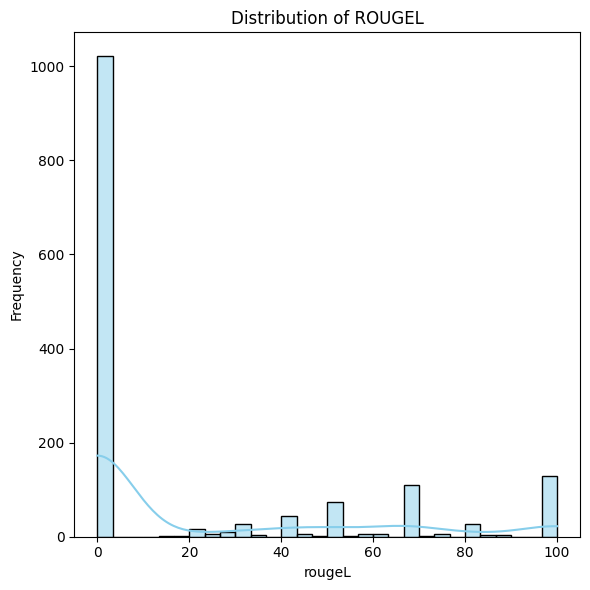

In [ ]:
plt.figure(figsize=(6, 6))
# metrics = ["rougeL", "bleu", "meteor", "bertscore_f1"]
metrics = ["rougeL"]

for i, metric in enumerate(metrics, 1):
    # plt.subplot(2, 2, i)
    sns.histplot(df[metric], bins=30, kde=True, color="skyblue")
    plt.title(f"Distribution of {metric.upper()}")
    plt.xlabel(metric)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### 결과 인사이트
**평균 성능 낮음** 
- 많은 샘플이 낮은 점수를 기록 → 전반적인 요약 품질이 낮음

**편향성** 
- 데이터나 모델이 특정 유형의 문서 요약에만 잘 동작하고 있음

**모델 일반화 부족** 
- 다양한 유형의 문서에서 일관된 성능을 보이지 못함

**정답 요약과의 거리 큼** 
- 모델이 생성한 요약이 실제 정답과 구조/표현이 많이 다름

**후처리 또는 전처리 문제 가능성** 
- 잘림, padding 오류, 특수문자 등으로 rouge가 0이 되는 사례 발생 가능

### 추후 개선 과제
1. **문서 유형별 Fine-tuning 실험** : 같은 모델이라도 도메인에 따라 요약 방식이 달라지므로 실제 성능이 개선될 가능성이 높음
2. **평가 지표 다변화** : ROUGE만으로는 의미 보존 여부 판단이 어려움 → BERTScore, BLEURT 등 의미 기반 지표를 추가
3. **하이퍼파라미터 및 자원 최적화** : 모델 사이즈 축소(예: distilled KoBART)도 고려하여 학습 속도 및 자원 효율 개선

# 요약 결과 확인

In [ ]:
sample = dataset["validation"][25]
input_text = sample["text"]

device = model.device  # 모델 디바이스 확인

# 입력 토큰 변환 및 디바이스 이동
inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
input_ids = inputs.input_ids.to(device)

# 요약 생성
output_ids = model.generate(input_ids, max_length=128, num_beams=4)
summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# 결과 출력
print("원문:", input_text[:300], "...")
print("정답 요약:", sample["summary"])
print("생성 요약:", summary)


원문: '해양의 축적, 미래를 쌓다'를 주제로 사흘간 열린 제13 회 세계해양포럼은 해양 분야 세계 석학들의 지식포럼이었다. 문재인 대통령이 "첨단 기술이 넘쳐나는 4 차 산업혁명 시대에도 가장 중요한 문제는 인간 경험과 지혜의 축적"이라고 서신에서 밝힌 것처럼 석학들이 제시한 대안은 불확실성 위기에서 항로를 알려주는 나침반이 되기에 충분했다. 1 일 마지막 세션에선 기조 강연자인 아지즈 바카스를 비롯해 각 분야에서 대안을 내놨던 토론자가 한자리에 모일 예정이라니 이번 포럼의 정점이 될 것으로 보인다. 현장 분위기도 예상을 뛰어넘었다고 한 ...
정답 요약: 제 13회 세계해양포럼에서는 '해양의 축적, 미래를 쌓다.'를 주제로 석학들이 혁신은 도전적 경험의 축적에서 비롯한다는 결론을 도출한 바 혁신의 대안이 부산의 비전으로 연계돼야 할 것이다.
생성 요약: '해양의 축적, 미래를 쌓다'를 주제로 사흘간 열린 제13회 세계해양포럼은 불확실성 위기에서 항로를 알려주는 나침반이 되기에 충분했고, 1 일 마지막 세션에선 기조 강연자인 아지즈 바카스를 비롯해 각 분야에서 대안을 내놨던 토론자가 한자리에 모일 예정이라 이번 포럼의 정점이 될 것으로 보인다.


# 회고 

## <어려웠던 점>
▶ transformers 버전 이슈로 인해 predict_with_generate, tokenizer 관련 오류 해결에 시간 소요

▶ fp16 활성화 시 GPU 자원 부족 → batch size 및 데이터 샘플 수 줄이는 방식으로 해결

▶ model_auto 파라미터 관련 오류 → 해결하지 못하여 제외하고 진행

▶ KoBART 로딩 오류 (MissingSchema 등) → 허깅페이스 연결 이슈와 캐시 문제를 해결


## <배운 것>
##### ▶ Hugging Face Trainer 구조와 학습 파이프라인에 대한 깊은 이해

이번 프로젝트에서 Hugging Face의 Trainer 클래스를 활용해 KoBART 기반 문서 요약 모델을 학습하며, Hugging Face 라이브러리가 제공하는 학습 파이프라인의 강력함과 유연함을 직접 체감했다.

Trainer는 단순히 모델을 학습시키는 도구가 아니라, 전체 학습 프로세스를 추상화한 프레임워크로 볼 수 있다. 

주요 특징은 다음과 같다:
- TrainingArguments를 통해 전체 학습 하이퍼파라미터, 로깅 전략, 평가 주기 등을 선언적으로 설정할 수 있다.
- Trainer 객체는 model, tokenizer, data_collator, compute_metrics, callback 등 구성요소들을 조립해서, 학습-검증-예측 전과정을 자동으로 처리한다.
- 내부적으로 accelerate 패키지를 통해 multi-GPU, mixed-precision(fp16/bf16), gradient accumulation 등의 최적화 기법도 간단히 사용할 수 있다.

이 프레임워크의 장점은 복잡한 훈련 로직을 반복 구현하지 않아도 되는 점과, 실험 반복의 효율성이다. 다양한 실험(하이퍼파라미터 튜닝, 데이터 전처리 방식 변경 등)을 일관된 방식으로 시도할 수 있었고, 이는 모델 개발의 생산성을 크게 높여준다.

---

#### ▶ 문서 요약 평가의 어려움과 ROUGE 지표 해석의 한계
요약은 정답이 하나가 아닌 문제다. 같은 내용을 표현하는 방식은 다양하고, ROUGE는 단지 정답 문장과의 표현 유사도만 측정할 뿐이다.

예를 들어, 모델이 생성한 요약이 문맥상 적절하고 핵심 정보를 잘 담고 있어도, 정답 요약과 단어 순서나 표현 방식이 다르면 ROUGE-L 점수는 낮게 나올 수 있다. 반대로, 의미가 어긋나도 우연히 단어가 겹치면 점수가 높을 수도 있다.

이를 통해 다음과 같은 한계를 실감했다:
- ROUGE는 구조적/표현적 유사성은 잘 측정하지만 의미적 유사성은 부족하다.
- ROUGE-L 분포를 보면 대부분 0~5 사이에 몰려있어도, 실제 요약이 모두 형편없다고 판단할 수 없다.
- 정성 평가나 BERTScore, human evaluation 같은 보완 지표의 필요성을 느꼈다.

---

#### ▶ 작은 하이퍼파라미터 조정이 큰 메모리 차이를 만든다는 것 
학습 중 batch_size, max_length, fp16, eval_steps, predict_with_generate=True 등의 설정을 바꾸는 것만으로도 GPU 메모리 사용량이 크게 변동되었다.

대표적인 사례:
- predict_with_generate=True → 평가 시 generate()를 호출해 요약을 생성하기 때문에, 메모리 폭증으로 OOM이 자주 발생.
- max_length를 512에서 1024로 변경 → 학습 속도 저하와 GPU 사용량 급증
- fp16=True는 메모리 최적화에 큰 도움이 되었지만, 일부 환경에서는 mps와 충돌

이 과정에서 느낀 점은:
- 하이퍼파라미터 하나가 전체 실험 성패를 좌우할 수 있다.
- 학습 전 작은 실험(메모리 프로파일링, 샘플 추론 테스트 등)은 필수다.
- 로컬 환경의 자원 한계를 명확히 인식하고, 이에 맞는 전략을 설계하는 능력이 중요하다.